In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

In [28]:
cv_scores = []
headings = []

In [29]:
headings.append('Folding Rate')
cv_scores.append(np.array([0.446631366, 0.516340344, 0.570094062, 0.565332574, 0.624347408]))

In [30]:
headings.append('Alpha vs Beta')
cv_scores.append(np.array([2.13397524e-01, 8.29545741e-01, 1.47718465e+00, 3.17996795e-01, 3.73447022e-01, 1.02578942e-01, 1.38647987e+00, 1.34123270e+00, 1.13576363e-04, 2.59680521e-02]))

In [31]:
headings.append('Transmembrane vs Globular')
cv_scores.append(np.array([0.7, 0.9, 0.6, 0.9, 1. , 0.5, 0.8, 0.8, 1. , 0.8]))

In [32]:
headings

['Folding Rate', 'Alpha vs Beta', 'Transmembrane vs Globular']

In [33]:
cv_scores

[array([0.44663137, 0.51634034, 0.57009406, 0.56533257, 0.62434741]),
 array([2.13397524e-01, 8.29545741e-01, 1.47718465e+00, 3.17996795e-01,
        3.73447022e-01, 1.02578942e-01, 1.38647987e+00, 1.34123270e+00,
        1.13576363e-04, 2.59680521e-02]),
 array([0.7, 0.9, 0.6, 0.9, 1. , 0.5, 0.8, 0.8, 1. , 0.8])]

/var/folders/16/_t_c8chd6vgc4dzy3l1fm5m00000gp/T/ipykernel_9153/3206118945.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = sns.barplot(data=np.array(cv_scores))


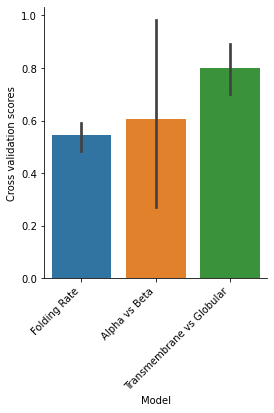

In [43]:
plt.figure(figsize=(4, 5))
x = sns.barplot(data=np.array(cv_scores))
x.set_xlabel('Model')
x.set_xticklabels(headings)
t = plt.setp(x.get_xticklabels(), ha="right", rotation=45)
x.set_ylabel('Cross validation scores')
sns.despine()

In [24]:
?sns.barplot